<a href="https://colab.research.google.com/github/bominwang/Bayesian-neural-network/blob/demo/Simple_bnn_in_pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import tqdm.auto 
from tqdm.auto import trange, tqdm

In [72]:
!pip3 install pyro-ppl 
import pyro
import pyro.distributions
import pyro.nn
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro.infer
from pyro.infer import Trace_ELBO
from pyro.infer import SVI
from pyro.infer import Predictive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


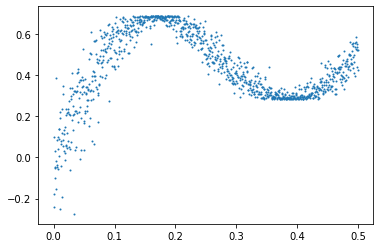

In [73]:
x = np.linspace(0, 0.5, 1000)
e = 0.02 * np.random.randn(x.shape[0])
y = x + 0.3 * np.sin(2 * np.pi * (x + e)) + 0.3 * np.sin(4 * np.pi *(x + e)) + e

plt.figure(1)
plt.plot(x, y, 'o', markersize = 1)
plt.show()

**Model**

In [74]:
class bnn(PyroModule):
  def __init__(self):
    super(bnn, self).__init__()

    # 定义第一层权重和偏置
    self.fc_1 = PyroModule[nn.Linear](1, 20)
    self.fc_1.weight = PyroSample(pyro.distributions.Normal(0.0, 1.0).expand([20, 1]).to_event(2))
    self.fc_1.bias = PyroSample(pyro.distributions.Normal(0.0, 1.0).expand([20]).to_event(1))

    # 定义第二层权重和偏置
    self.fc_2 = PyroModule[nn.Linear](20, 20)
    self.fc_2.weight = PyroSample(pyro.distributions.Normal(0.0, 1.0).expand([20, 20]).to_event(2))
    self.fc_2.bias = PyroSample(pyro.distributions.Normal(0.0, 1.0).expand([20]).to_event(1))

    # 定义第三层权重和偏置
    self.fc_3 = PyroModule[nn.Linear](20, 1)
    self.fc_3.weight = PyroSample(pyro.distributions.Normal(0.0, 1.0).expand([1, 20]).to_event(2))
    self.fc_3.bias = PyroSample(pyro.distributions.Normal(0.0, 1.0).expand([1]).to_event(1))

    self.relu = nn.ReLU()
  
  def forward(self, x, y = None):
    x = x.reshape(-1, 1)
    x = self.relu(self.fc_1(x))
    x = self.relu(self.fc_2(x))
    mu = self.fc_3(x).squeeze()
    
    sigma = pyro.sample('sigma', pyro.distributions.Uniform(0.0, 1.0))

    with pyro.plate('data', x.shape[0]):
      obs = pyro.sample('obs', pyro.distributions.Normal(mu, sigma), obs = y)
    
    return mu

**Training**

In [75]:
model = bnn()
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
adam = pyro.optim.Adam({'lr': 1e-3})
svi = SVI(model, guide, adam, loss = Trace_ELBO())

loss = []
epoch = trange(500)

x_train = torch.from_numpy(x).float()
y_train = torch.from_numpy(y).float()

for index in epoch:
  l = svi.step(x_train, y_train)
  loss.append(l)



  0%|          | 0/500 [00:00<?, ?it/s]

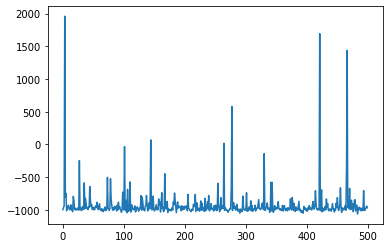

In [76]:
plt.figure(2)
plt.plot(loss)

**Prediction**

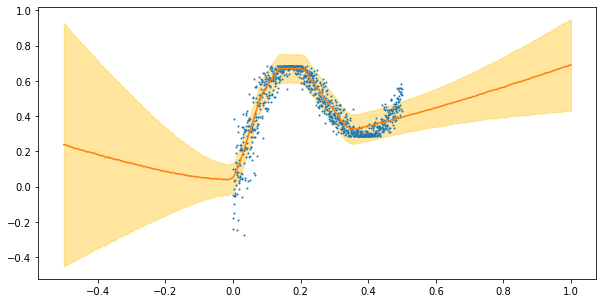

In [78]:
predictive = Predictive(model, guide=guide, num_samples=3000)

x_test = torch.linspace(-0.5, 1, 500)
preds = predictive(x_test)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, 'o', markersize=1)
ax.plot(x_test, y_pred)
ax.fill_between(x_test, y_pred - y_std, y_pred + y_std,
                alpha=0.5, color='#ffcd3c');